## Semantic Segmentation with _Fully Convolutional Networks_ in Keras [SOLUTION]

(by: [Pascal Graf](mailto:pascal.graf@hs-heilbronn.de), Heilbronn University, Germany, May 2018)

This tutorial shows how to segment street scene images with fully convolutional networks in Keras. 

### Imports
First of all we need to import the required modules for this project.
This includes the standard moduls for tensor calculations, file handling, visualization and image processing as well as keras

In [1]:
# Important modules for tensor calculations, file handling, visualization and image processing
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import csv
import pickle
from matplotlib import gridspec
import datetime

%matplotlib inline

# import keras and tensorflow 
from utils.segmentation_utils import *
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Input, Model, layers, preprocessing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Conv2DTranspose, Cropping2D
from tensorflow.keras.applications.inception_v3 import decode_predictions, preprocess_input, InceptionV3
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

**If you get a "Failed to get convolution algorithm" error when trying to predict with a pretrained network uncomment the following code.
The issue is known for RTX graphic cards and described [here](https://medium.com/@JeansPantRushi/fix-for-tensorflow-v2-failed-to-get-convolution-algorithm-b367a088b56e)**

In [2]:
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Load a pretrained Model
The next step is to load **InceptionV3** from Keras which has been pretrained with ImageNet to classify images.
> __TODO: Print the summary of the loaded model and try to figure out which layers we have to replace.__

In [3]:
# Clear the current session to remove old models from memory
K.clear_session()
# Load the original pretrained model
inception_model = InceptionV3()
# Print the model summary
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Classify an Image
Now we take a look at how well the pretrained network performs on an classification task.
> __TODO: Open an image from your harddrive and predict an ImageNet class for it .__

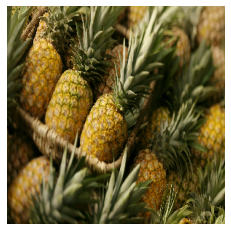

Top 5 predictions of the model:

Class:		 Probability:

pineapple 	   98.55%
ear 	    0.06%
Doberman 	    0.02%
cardoon 	    0.02%
jackfruit 	    0.02%


In [4]:
# TODO: Add the path to an example image
img_path = 'test.jpg'
# Load the image and resize it
img = image.load_img(img_path, target_size=(299, 299))

# TODO: Visualize the image using plt
plt.imshow(img)
plt.axis("off")
plt.show()

# Preprocess the input for the network
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# TODO: Predict the top five classifications for your image
preds = inception_model.predict(x)
decoded_preds = decode_predictions(preds, top=5)[0]

# TODO: Print the top five predictions and the respective probability
# HINT: The Predictions are saved in a list with the format: [[class_0, classname_0, probability_0], [class_1, ...]]
print("Top 5 predictions of the model:\n")
print("Class:\t\t Probability:\n")
for pred in decoded_preds:
    print("{} \t  {:6.2f}%".format(pred[1], pred[2]*100))

### Modify the Model Architecture to get a _Fully Convolutional Network_
Now we want to modify the **InceptionV3** Architecture.
This process is divided into multiple steps:
> __TODO: __
>>1. Load the pretrained network model without the classifying layers at the end
>>2. Get hold of the outputs of the first and the last layer of the remaining model.
>>3. Add a **Conv2D** Layer with 13 layers representing the 13 classes in the _Synthia_-Dataset. The width and height of the input must remain unchanged!
>>4. Add a **Conv2DTranspose** Layer with 13 layers. Make sure to choose the Stride and the Kernel Size so that the output dimensions are **at least (720, 960)**. Remember: The Output Dimensions can be calculated like this: $O = S(I-1)+K$.
>>5. If the Output Dimensions don't exactly fit (720,960) use a **Cropping2D** Layer to crop the borders.
>>6. Build the Model and print its Summary

> HINT: If you're not sure about the output shape of your model just print the summary and adjust the **Conv2DTranspose** and the **Cropping2D** layer accordingly.


In [6]:
# Repeating the loading process of the pretrained model to make sure we always start from the same point.
# Clear the current session to remove old models from memory
K.clear_session()
# Load the original pretrained model. To remove the classifying layers just set the include_top flag to False
inception_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(720,960,3))

# Freeze all layers but the last 31:
for layer in inception_model.layers[:-31]:
    layer.trainable = False
    
# TODO: Get hold of the output of the first and last layer of the model.
image_input = inception_model.layers[0].output
model_output = inception_model.layers[-1].output

# TODO: Append a Convolutional layer with 13 layers and a kernel size of 1 to the end of the network.
x = Conv2D(13, 1, padding="same", name="score_1")(model_output)

# Sample up the output to the original (720, 960) input size. You might need to Crop the output to get the desired size.
x = Conv2DTranspose(13, kernel_size=69, strides=33, name="upscore1", activation="softmax")(x)
x = Cropping2D(((4,5), (0,0)), name="output")(x)

# Build the model using the image_input and x
model = Model(image_input, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 720, 960, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 359, 479, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 359, 479, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 359, 479, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Compile your new Segmentation Model
> __TODO: Compile your model using the categorical_crossentropy and an optimizer of your choice with appropriate parameters.__

In [7]:
model.compile(loss= keras.losses.categorical_crossentropy,
             optimizer= keras.optimizers.Adam(lr=0.0001),
             metrics=['accuracy'])

### Train the model
Finally we want to train our model with a small part of the _Synthia_-Dataset. The framework the preprocess the images and labels, obtain batches, train the network and predict segmentations has already been prepared for you (_lucky you!_).

In [8]:
# Print Out the colormap of the Synthia-Dataset with the respective class names.
colormap, label_names = get_colormap('synthia')
for color, name in zip(colormap, label_names):
    print(color,"\t", name)
# Create the segmentation framework from a previously imported module
create_segmentation_framework(r"./data/images/train", r"./data/labels/train", r"./data/images/test", r"./data/labels/test")

Successfully opened the synthia colormap which consists of 13 classes.
[0 0 0] 	 void
[128 128 128] 	 sky
[128   0   0] 	 building
[128  64 128] 	 road
[  0   0 192] 	 sidewalk
[ 64  64 128] 	 fence
[128 128   0] 	 vegetation
[192 192 128] 	 pole
[ 64   0 128] 	 car
[192 128 128] 	 sign
[64 64  0] 	 pedestrian
[  0 128 192] 	 cyclist
[  0 175   0] 	 lane
Successfully opened the synthia colormap which consists of 13 classes.


**Predict Segmentation**: Try this before and after the training. The output before training should look like a random noise of different colors 

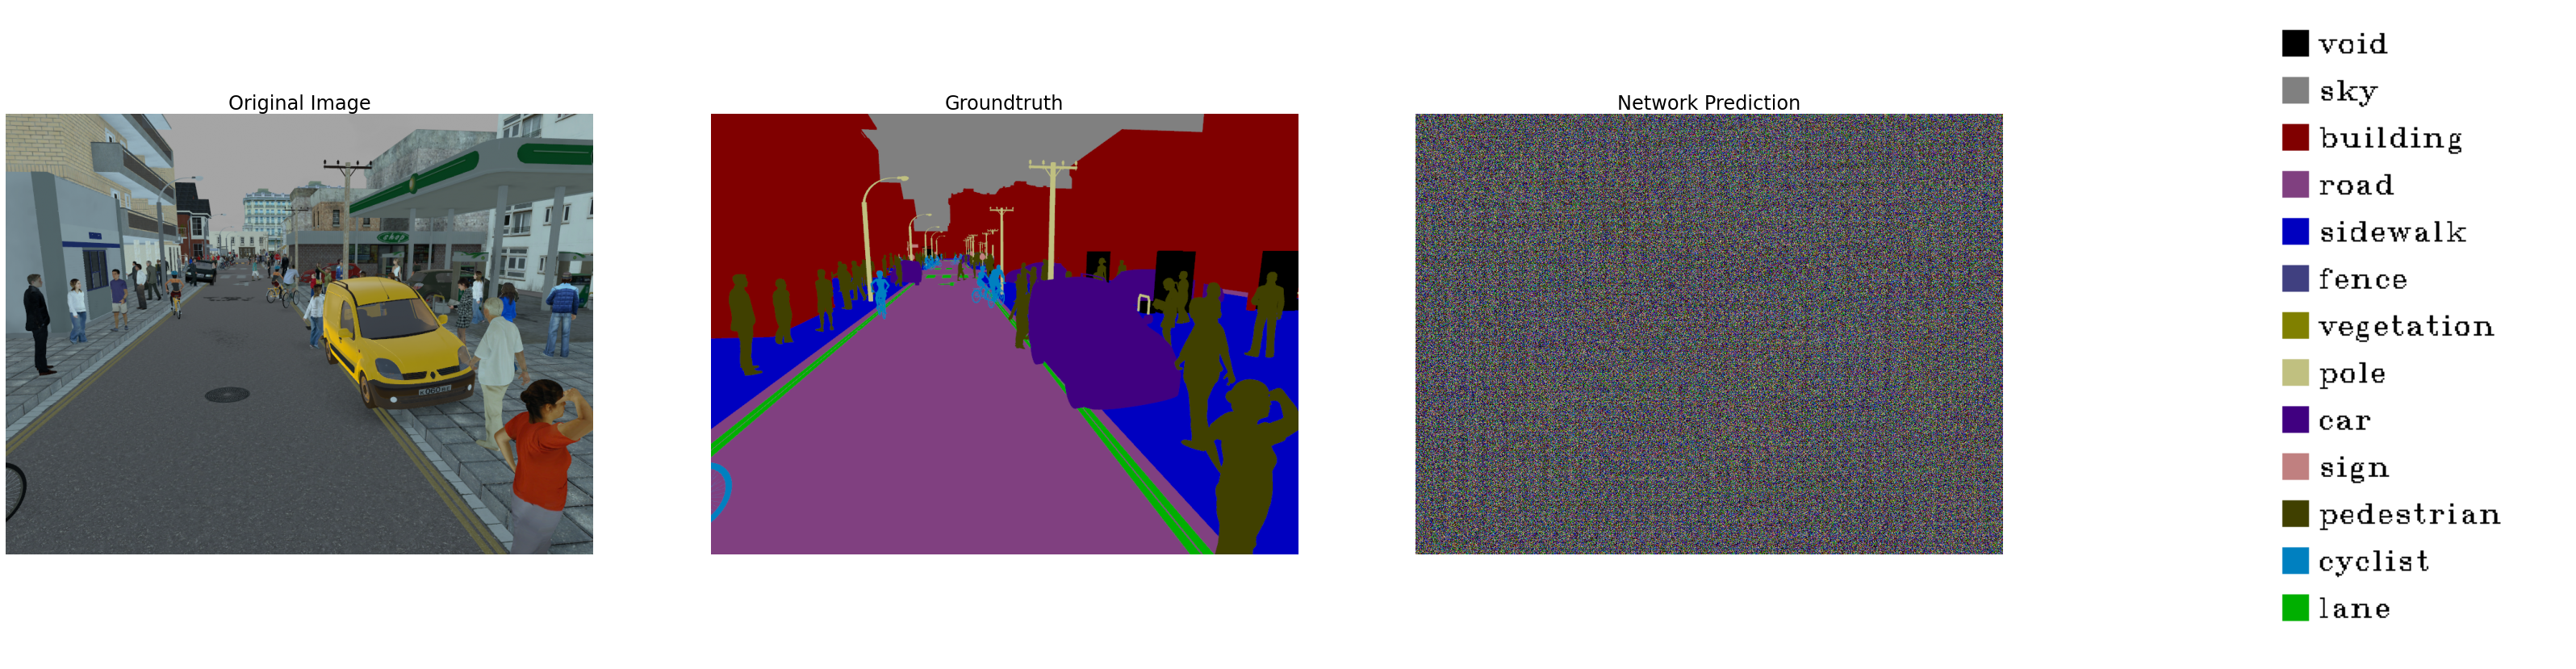

In [9]:
predict_segmentation(model, save_img=False)

**Start Training:** This might take quite a long time if your running Tensorflow on a CPU. At any time your can stop the training by pressing the interrupt button at the top of the notebook. The training progress until that point will be saved anyways.

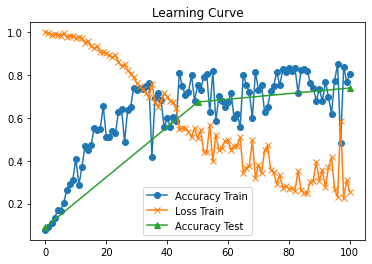

Epoch: 1/1	 Batch: 120/120	 Loss on Training Batch: 0.481, Accuracy on Training Batch: 85.738%, Accuracy on last Test Batch 73.960%
 Finished Training!


In [10]:
train_metrics, test_metrics = train_segmentation(model, epochs=1, batch_size=1, verbose=2, test_num=3, auto_save=False)

In [ ]:
model = load_model("segmentation_model_20180516_1918")

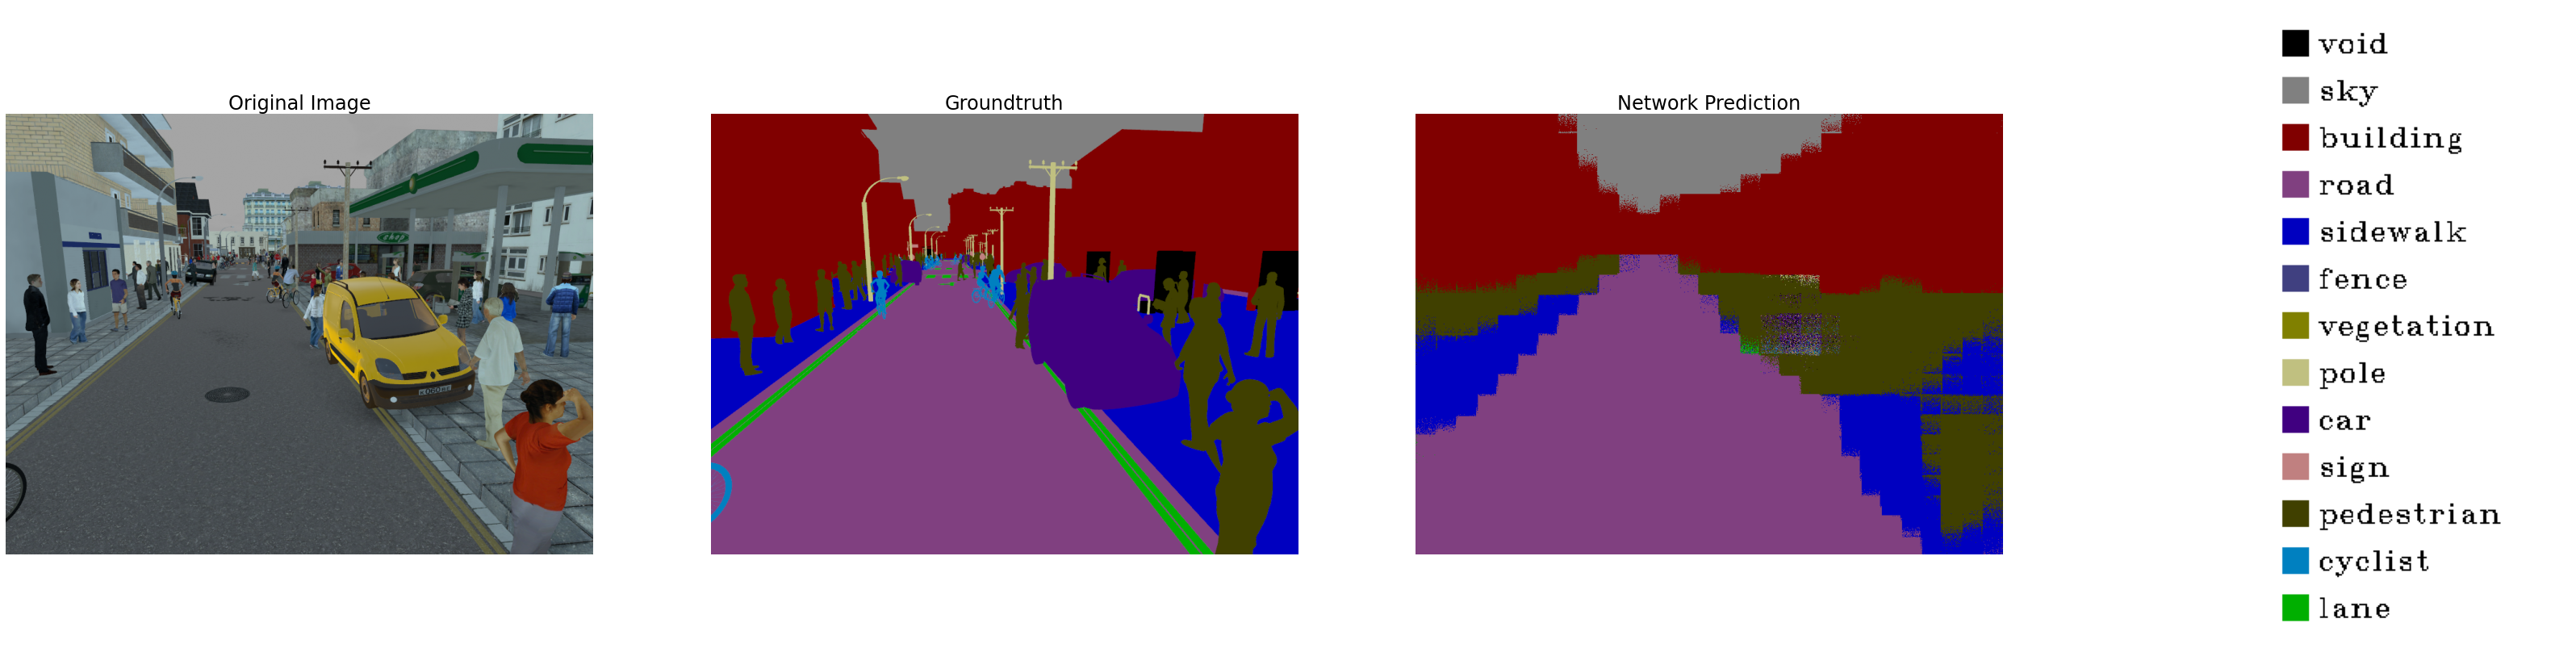

In [11]:
predict_segmentation(model, save_img=False)